- 팀의 출루율(OBP)이 높을수록 팀 승률은 높을 것이다.
- 팀의 장타율(SLG)이 높을수록 팀 승률은 높을 것이다.
- 팀의 wRC+가 높을수록 팀 승률은 높을 것이다.
- 팀의 WAR이 높을수록 팀 승률은 높을 것이다.
- 팀 평균 자책점(ERA)이 낮을수록 팀 승률은 높을 것이다.
- 팀의 FIP가 낮을수록 팀 승률은 높을 것이다.

In [1]:
import pandas as pd
import numpy as np

In [27]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"   # macOS 한글 폰트
plt.rcParams["axes.unicode_minus"] = False    # 마이너스 깨짐 방지

In [ ]:
bat = pd.read_csv("../data/processed/bat_analysis_pa50_2021_2025.csv")
pitch = pd.read_csv("../data/processed/pitch_analysis_ip30_2021_2025.csv")
win = pd.read_csv("../data/team_win_rate_2022_2025.csv")

In [3]:
# 타자 데이터 팀 지표 만들기
bat_team = (
    bat.groupby(["Year", "Team"]).agg({
        "OBP": "mean",
        "SLG": "mean",
        "wRC+": "mean",
        "WAR": "sum"
    })
    .reset_index()
)
bat_team.head()

,Year,Team,OBP,SLG,wRC+,WAR
0,2022,KIA,0.328412,0.371765,97.470588,30.72
1,2022,LG,0.321526,0.371211,98.678947,32.43
2,2022,SSG,0.320833,0.377444,92.461111,29.31
3,2022,한화,0.299632,0.330737,75.021053,14.70
4,2023,KIA,0.330316,0.367421,97.126316,26.68


In [4]:
# 투수 데이터 팀 지표 만들기
pitch_team = (pitch.groupby(["Year", "Team"]).agg({
        "ERA": "mean",
        "FIP": "mean",
        "WAR": "sum"
    })
    .reset_index()
)
pitch_team.head()


,Year,Team,ERA,FIP,WAR
0,2022,KIA,4.008462,4.010000,18.65
1,2022,LG,3.137500,3.750000,26.66
2,2022,SSG,3.923846,4.166154,25.32
3,2022,한화,4.698235,4.514706,7.11
4,2023,KIA,4.116250,4.420000,18.63


In [5]:
# 타자 + 투수
team_metric = bat_team.merge(
    pitch_team,
    on=["Year", "Team"],
    how="inner"
)
team_metric.head()

,Year,Team,OBP,SLG,wRC+,WAR_x,ERA,FIP,WAR_y
0,2022,KIA,0.328412,0.371765,97.470588,30.72,4.008462,4.010000,18.65
1,2022,LG,0.321526,0.371211,98.678947,32.43,3.137500,3.750000,26.66
2,2022,SSG,0.320833,0.377444,92.461111,29.31,3.923846,4.166154,25.32
3,2022,한화,0.299632,0.330737,75.021053,14.70,4.698235,4.514706,7.11
4,2023,KIA,0.330316,0.367421,97.126316,26.68,4.116250,4.420000,18.63


In [6]:

team_metric = team_metric.rename(columns={"Year": "year", "Team": "team", "WAR_x":"WAR_bat","WAR_y":"WAR_pitch"})

win = win.rename(columns={"Year": "year", "Team": "team"})

df = team_metric.merge(win, on=["year", "team"], how="inner")

df.head(), df.shape

(   year team       OBP       SLG       wRC+  WAR_bat       ERA       FIP  \
 0  2022  KIA  0.328412  0.371765  97.470588    30.72  4.008462  4.010000   
 1  2022   LG  0.321526  0.371211  98.678947    32.43  3.137500  3.750000   
 2  2022  SSG  0.320833  0.377444  92.461111    29.31  3.923846  4.166154   
 3  2022   한화  0.299632  0.330737  75.021053    14.70  4.698235  4.514706   
 4  2023  KIA  0.330316  0.367421  97.126316    26.68  4.116250  4.420000   
 
    WAR_pitch  win_rate  
 0      18.65     0.490  
 1      26.66     0.613  
 2      25.32     0.629  
 3       7.11     0.324  
 4      18.63     0.514  ,
 (16, 10))

In [7]:
df = team_metric.merge(win,
    on=["year", "team"],
    how="inner"
)

In [8]:
df["WAR_total"] = df["WAR_bat"].fillna(0) + df["WAR_pitch"].fillna(0)


In [9]:
print(df.shape)
print(df.columns)

(16, 11)
Index(['year', 'team', 'OBP', 'SLG', 'wRC+', 'WAR_bat', 'ERA', 'FIP',
       'WAR_pitch', 'win_rate', 'WAR_total'],
      dtype='object')


In [10]:
df.isna().sum()
df[["year","team"]].drop_duplicates().sort_values(["year","team"])

,year,team
0,2022,KIA
1,2022,LG
2,2022,SSG
3,2022,한화
4,2023,KIA
5,2023,LG
6,2023,SSG
7,2023,한화
8,2024,KIA
9,2024,LG


## 가설검증

In [11]:
hyp_cols = ["OBP", "SLG", "wRC+", "WAR_total", "ERA", "FIP"]
target = "win_rate"

In [12]:
# 승률과의 상관계수
corr_series = df[[target] + hyp_cols].corr()[target].drop(target).sort_values(ascending=False)
corr_series

#지표가 커질수록
#양수 : 승률 높이는데 영향
#음수 : 승률 낮추는데 영향

WAR_total    0.909901
SLG          0.731321
wRC+         0.716202
OBP          0.607661
FIP         -0.397196
ERA         -0.625989
Name: win_rate, dtype: float64

In [13]:
import statsmodels.api as sm

results = []

for xcol in hyp_cols:
    temp = df[[target, xcol]].dropna()

    X = sm.add_constant(temp[xcol])
    y = temp[target]

    model = sm.OLS(y, X).fit()

    results.append({
        "metric": xcol,
        "n": len(temp),
        "coef": float(model.params[xcol]),
        "p_value": float(model.pvalues[xcol]),
        "r2": float(model.rsquared)
    })

reg_result = pd.DataFrame(results).sort_values("p_value")
reg_result


,metric,n,coef,p_value,r2
3,WAR_total,16,0.006507,0.000001,0.827920
1,SLG,16,2.484264,0.001285,0.534830
2,wRC+,16,0.005134,0.001803,0.512945
4,ERA,16,-0.094819,0.009485,0.391862
0,OBP,16,3.016834,0.012528,0.369252
5,FIP,16,-0.086966,0.127662,0.157765


In [14]:
reg_result["support"] = reg_result["p_value"].apply(lambda p: "지지(유의)" if p < 0.05 else "미지지/약함")
reg_result

,metric,n,coef,p_value,r2,support
3,WAR_total,16,0.006507,0.000001,0.827920,지지(유의)
1,SLG,16,2.484264,0.001285,0.534830,지지(유의)
2,wRC+,16,0.005134,0.001803,0.512945,지지(유의)
4,ERA,16,-0.094819,0.009485,0.391862,지지(유의)
0,OBP,16,3.016834,0.012528,0.369252,지지(유의)
5,FIP,16,-0.086966,0.127662,0.157765,미지지/약함


In [15]:
# 한화만 추려서 연도별 지표 변화 확인
hanwha = df[df["team"] == "한화"].sort_values("year")
hanwha[["year", "win_rate"] + hyp_cols]


,year,win_rate,OBP,SLG,wRC+,WAR_total,ERA,FIP
3,2022,0.324,0.299632,0.330737,75.021053,21.81,4.698235,4.514706
7,2023,0.420,0.301350,0.316850,71.675000,29.80,4.414118,4.244118
11,2024,0.465,0.336952,0.373619,85.457143,31.88,4.976667,4.865000
15,2025,0.593,0.329529,0.375941,93.294118,52.43,3.646429,3.836429


In [16]:
corr_series

WAR_total    0.909901
SLG          0.731321
wRC+         0.716202
OBP          0.607661
FIP         -0.397196
ERA         -0.625989
Name: win_rate, dtype: float64

In [17]:
reg_result

,metric,n,coef,p_value,r2,support
3,WAR_total,16,0.006507,0.000001,0.827920,지지(유의)
1,SLG,16,2.484264,0.001285,0.534830,지지(유의)
2,wRC+,16,0.005134,0.001803,0.512945,지지(유의)
4,ERA,16,-0.094819,0.009485,0.391862,지지(유의)
0,OBP,16,3.016834,0.012528,0.369252,지지(유의)
5,FIP,16,-0.086966,0.127662,0.157765,미지지/약함


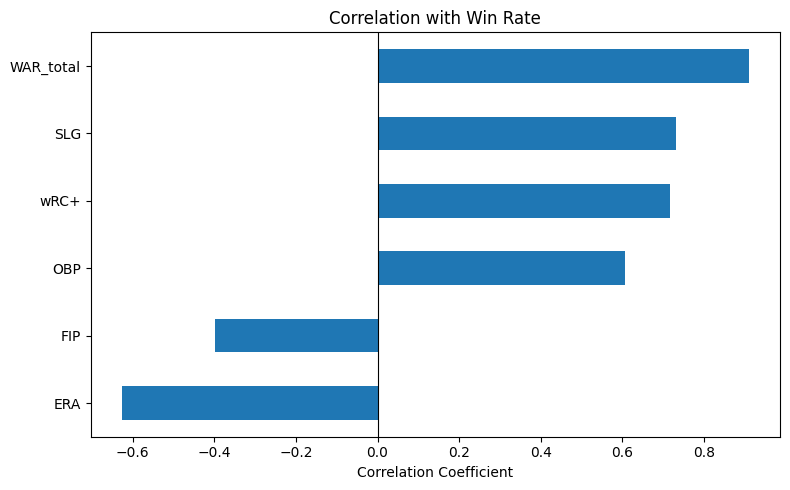

In [18]:
import matplotlib.pyplot as plt

corr_series = corr_series.sort_values()

plt.figure(figsize=(8, 5))
corr_series.plot(kind="barh")
plt.axvline(0, color="black", linewidth=0.8)

plt.title("Correlation with Win Rate")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()


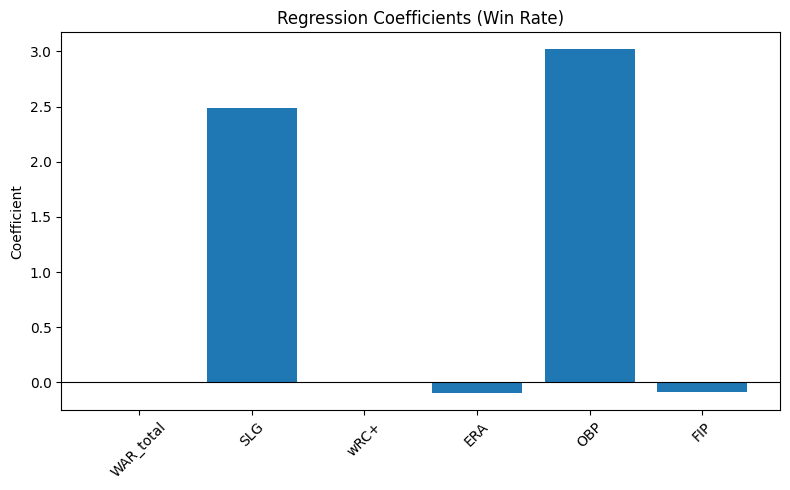

In [19]:
plt.figure(figsize=(8, 5))
plt.bar(reg_result["metric"], reg_result["coef"])
plt.axhline(0, color="black", linewidth=0.8)

plt.title("Regression Coefficients (Win Rate)")
plt.ylabel("Coefficient")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


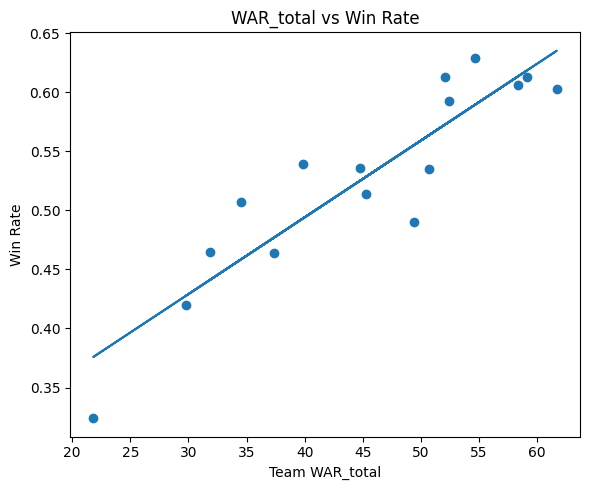

In [20]:
plt.figure(figsize=(6, 5))
plt.scatter(df["WAR_total"], df["win_rate"])

# 회귀선
import numpy as np
m, b = np.polyfit(df["WAR_total"], df["win_rate"], 1)
plt.plot(df["WAR_total"], m*df["WAR_total"] + b)

plt.title("WAR_total vs Win Rate")
plt.xlabel("Team WAR_total")
plt.ylabel("Win Rate")
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / x.std(ddof=0)


In [22]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaled_results = []

for col in ["OBP","SLG","wRC+","WAR_total","ERA","FIP"]:
    temp = df[[col, "win_rate"]].dropna()

    X = zscore(temp[col])
    y = temp["win_rate"].astype(float)

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    scaled_results.append({
        "metric": col,
        "std_coef": float(model.params.iloc[1]),
        "p_value": float(model.pvalues.iloc[1]),
        "r2": float(model.rsquared)
    })

scaled_df = pd.DataFrame(scaled_results).sort_values("p_value")
scaled_df

,metric,std_coef,p_value,r2
3,WAR_total,0.073445,0.000001,0.827920
1,SLG,0.059030,0.001285,0.534830
2,wRC+,0.057810,0.001803,0.512945
4,ERA,-0.050528,0.009485,0.391862
0,OBP,0.049049,0.012528,0.369252
5,FIP,-0.032061,0.127662,0.157765


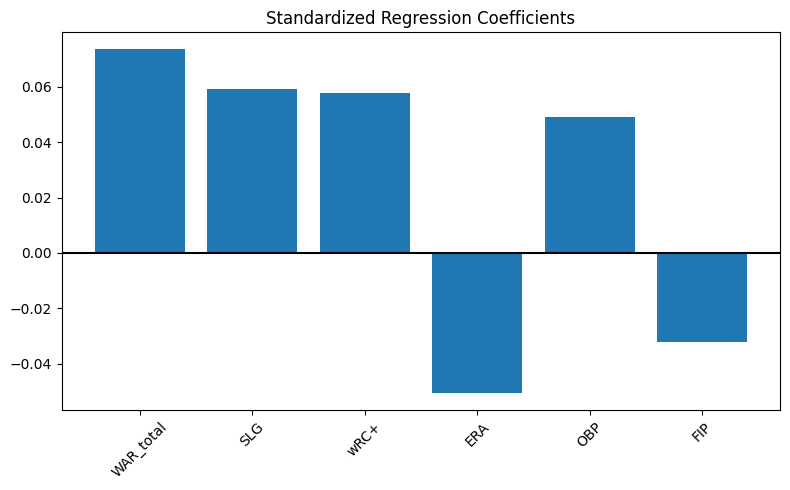

In [23]:
plt.figure(figsize=(8,5))
plt.bar(scaled_df["metric"], scaled_df["std_coef"])
plt.axhline(0, color="black")
plt.title("Standardized Regression Coefficients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
reg_result

,metric,n,coef,p_value,r2,support
3,WAR_total,16,0.006507,0.000001,0.827920,지지(유의)
1,SLG,16,2.484264,0.001285,0.534830,지지(유의)
2,wRC+,16,0.005134,0.001803,0.512945,지지(유의)
4,ERA,16,-0.094819,0.009485,0.391862,지지(유의)
0,OBP,16,3.016834,0.012528,0.369252,지지(유의)
5,FIP,16,-0.086966,0.127662,0.157765,미지지/약함


---

In [1]:
# ============================================================
# 0) 라이브러리
# ============================================================
import pandas as pd
import numpy as np

import scipy.stats as st
import statsmodels.api as sm

import matplotlib.pyplot as plt

# ============================================================
# 1) 데이터 로드
# ============================================================
# (너가 업로드한 파일 경로 기준)
BAT_PATH = "../data/raw/kbo_batting_stats_by_season_1982-2025.csv"
bat = pd.read_csv(BAT_PATH)

# ------------------------------------------------------------
# 2) 최근 5개년 필터링 (2021~2025)
# ------------------------------------------------------------
YEARS = [2021, 2022, 2023, 2024, 2025]
bat5 = bat[bat["Year"].isin(YEARS)].copy()

# 수치형 변환(혹시 문자열로 읽힌 경우 대비)
num_cols = ["PA", "AB", "H", "BB", "HP", "SF", "SO", "wRC+", "TB", "HR"]
for c in num_cols:
    if c in bat5.columns:
        bat5[c] = pd.to_numeric(bat5[c], errors="coerce")

# ------------------------------------------------------------
# 3) 팀-연도 단위로 집계 (선수→팀 합산)
#    - OBP 등은 "팀 공식값"으로 재계산해야 함
# ------------------------------------------------------------
# wRC+는 선수별 지표라서 팀값은 PA가중평균(근사)로 계산
bat5["wRCxPA"] = bat5["wRC+"] * bat5["PA"]

team_year = (
    bat5.groupby(["Year", "Team"], as_index=False)
        .agg(
            PA=("PA", "sum"),
            AB=("AB", "sum"),
            H=("H", "sum"),
            BB=("BB", "sum"),
            HBP=("HP", "sum"),   # HP가 사구(HBP)로 들어있음
            SF=("SF", "sum"),
            SO=("SO", "sum"),
            wRCxPA=("wRCxPA", "sum"),
        )
)

# ------------------------------------------------------------
# 4) 가설 검증용 파생변수 생성
# ------------------------------------------------------------
# 팀 OBP 공식 재계산
team_year["OBP"] = (team_year["H"] + team_year["BB"] + team_year["HBP"]) / (
    team_year["AB"] + team_year["BB"] + team_year["HBP"] + team_year["SF"]
)

# 볼넷+사구 비율, 삼진 비율
team_year["BB_HBP_PA"] = (team_year["BB"] + team_year["HBP"]) / team_year["PA"]
team_year["SO_PA"] = team_year["SO"] / team_year["PA"]

# 팀 wRC+ (PA 가중평균)
team_year["wRC+_PAw"] = team_year["wRCxPA"] / team_year["PA"]

# ------------------------------------------------------------
# 5) (선택) 최근 5년 우승팀 마킹
#     - 한국시리즈 우승 기준으로 매핑(필요하면 수정 가능)
# ------------------------------------------------------------
champ_map = {
    2021: "KT",
    2022: "SSG",
    2023: "LG",
    2024: "KIA",
    2025: "LG",
}
team_year["is_champ"] = team_year.apply(
    lambda r: champ_map.get(int(r["Year"])) == r["Team"], axis=1
)

# ============================================================
# 6) 가설 검증 함수: Pearson r + p-value + 단순회귀(OLS) + R^2
# ============================================================
def corr_and_reg(df: pd.DataFrame, xcol: str, ycol: str) -> dict:
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())

    # Pearson correlation
    r, p_corr = st.pearsonr(x[mask], y[mask])

    # Simple OLS regression: y = a + b*x
    X = sm.add_constant(x[mask])
    model = sm.OLS(y[mask], X).fit()

    return {
        "n": int(mask.sum()),
        "pearson_r": float(r),
        "corr_p_value": float(p_corr),
        "reg_intercept": float(model.params.iloc[0]),
        "reg_coef": float(model.params.iloc[1]),
        "reg_p_value": float(model.pvalues.iloc[1]),
        "r2": float(model.rsquared),
    }

# ============================================================
# 7) 가설 3개 검증 (10개팀×5년 = 50개 team-year)
# ============================================================
results = []

# H1: (BB+HBP)/PA ↑ => OBP ↑
results.append({
    "Hypothesis": "H1: (BB+HBP)/PA ↑  =>  OBP ↑",
    **corr_and_reg(team_year, "BB_HBP_PA", "OBP")
})

# H2: SO/PA ↓ => OBP ↑  (상관계수는 음수로 나와야 정상)
results.append({
    "Hypothesis": "H2: SO/PA ↓  =>  OBP ↑",
    **corr_and_reg(team_year, "SO_PA", "OBP")
})

# H3: OBP ↑ => wRC+ ↑
results.append({
    "Hypothesis": "H3: OBP ↑  =>  wRC+ ↑",
    **corr_and_reg(team_year, "OBP", "wRC+_PAw")
})

tests_df = pd.DataFrame(results).round(6)
print(tests_df)

# ============================================================
# 8) (선택) 우승팀 5팀 vs 전체 평균 비교
# ============================================================
champ_df = team_year[team_year["is_champ"]].copy()

summary_df = pd.DataFrame({
    "Group": ["Champions (2021-2025)", "All teams (2021-2025)"],
    "n": [len(champ_df), len(team_year)],
    "OBP_mean": [champ_df["OBP"].mean(), team_year["OBP"].mean()],
    "BB+HBP/PA_mean": [champ_df["BB_HBP_PA"].mean(), team_year["BB_HBP_PA"].mean()],
    "SO/PA_mean": [champ_df["SO_PA"].mean(), team_year["SO_PA"].mean()],
    "wRC+_PAw_mean": [champ_df["wRC+_PAw"].mean(), team_year["wRC+_PAw"].mean()],
}).round(6)

print("\n--- Champions vs All Teams (Means) ---")
print(summary_df)

# ============================================================
# 9) 산점도 + 회귀직선 저장 (발표용)
#    (색 지정 안 함: 기본값)
# ============================================================
def save_scatter_with_fit(df, xcol, ycol, out_path, title):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())
    x = x[mask]; y = y[mask]

    # fit
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model.params.iloc[0] + model.params.iloc[1] * xs

    plt.figure()
    plt.scatter(x, y)
    plt.plot(xs, ys)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()

save_scatter_with_fit(team_year, "BB_HBP_PA", "OBP",
                      "plot_H1_BB_HBP_PA_vs_OBP.png",
                      "H1: (BB+HBP)/PA vs OBP (2021-2025, team-year)")

save_scatter_with_fit(team_year, "SO_PA", "OBP",
                      "plot_H2_SO_PA_vs_OBP.png",
                      "H2: SO/PA vs OBP (2021-2025, team-year)")

save_scatter_with_fit(team_year, "OBP", "wRC+_PAw",
                      "plot_H3_OBP_vs_wRCplus.png",
                      "H3: OBP vs wRC+ (2021-2025, team-year)")

# ============================================================
# 10) 결과 CSV 저장 (팀-연도 데이터 / 가설검증 결과 / 요약)
# ============================================================
team_year.to_csv("kbo_team_year_2021_2025_processed.csv", index=False, encoding="utf-8-sig")
tests_df.to_csv("kbo_hypothesis_tests_2021_2025.csv", index=False, encoding="utf-8-sig")
summary_df.to_csv("kbo_champ_vs_all_summary_2021_2025.csv", index=False, encoding="utf-8-sig")

print("\n[Saved files]")
print("- kbo_team_year_2021_2025_processed.csv")
print("- kbo_hypothesis_tests_2021_2025.csv")
print("- kbo_champ_vs_all_summary_2021_2025.csv")
print("- plot_H1_BB_HBP_PA_vs_OBP.png")
print("- plot_H2_SO_PA_vs_OBP.png")
print("- plot_H3_OBP_vs_wRCplus.png")


                     Hypothesis   n  pearson_r  corr_p_value  reg_intercept  \
0  H1: (BB+HBP)/PA ↑  =>  OBP ↑  50   0.492420      0.000281       0.278408   
1        H2: SO/PA ↓  =>  OBP ↑  50  -0.530483      0.000074       0.404582   
2         H3: OBP ↑  =>  wRC+ ↑  50   0.717948      0.000000     -64.462034   

     reg_coef  reg_p_value        r2  
0    0.591122     0.000281  0.242478  
1   -0.337551     0.000074  0.281412  
2  481.865143     0.000000  0.515450  

--- Champions vs All Teams (Means) ---
                   Group   n  OBP_mean  BB+HBP/PA_mean  SO/PA_mean  \
0  Champions (2021-2025)   5   0.35668        0.113913    0.169233   
1  All teams (2021-2025)  50   0.34168        0.107038    0.186348   

   wRC+_PAw_mean  
0     111.413648  
1     100.181837  

[Saved files]
- kbo_team_year_2021_2025_processed.csv
- kbo_hypothesis_tests_2021_2025.csv
- kbo_champ_vs_all_summary_2021_2025.csv
- plot_H1_BB_HBP_PA_vs_OBP.png
- plot_H2_SO_PA_vs_OBP.png
- plot_H3_OBP_vs_wRCplus.png

In [3]:
# ============================================================
# 0) 라이브러리
# ============================================================
import pandas as pd
import numpy as np

import scipy.stats as st
import statsmodels.api as sm

import matplotlib.pyplot as plt

# ============================================================
# 1) 데이터 로드
# ============================================================
BAT_PATH = "../data/raw/kbo_batting_stats_by_season_1982-2025.csv"
bat = pd.read_csv(BAT_PATH)

# ============================================================
# 2) 최근 5개년 필터링 (2021~2025)
# ============================================================
YEARS = [2021, 2022, 2023, 2024, 2025]
bat5 = bat[bat["Year"].isin(YEARS)].copy()

# 수치형 컬럼 변환
num_cols = ["PA", "AB", "H", "BB", "HP", "SF", "SO", "wRC+", "TB", "HR"]
for c in num_cols:
    if c in bat5.columns:
        bat5[c] = pd.to_numeric(bat5[c], errors="coerce")

# ============================================================
# 3) 팀-연도(team-year) 단위로 집계
# ============================================================
# wRC+는 PA 가중평균으로 계산
bat5["wRCxPA"] = bat5["wRC+"] * bat5["PA"]

team_year = (
    bat5.groupby(["Year", "Team"], as_index=False)
        .agg(
            PA=("PA", "sum"),
            AB=("AB", "sum"),
            H=("H", "sum"),
            BB=("BB", "sum"),
            HBP=("HP", "sum"),
            SF=("SF", "sum"),
            SO=("SO", "sum"),
            wRCxPA=("wRCxPA", "sum"),
        )
)

# ============================================================
# 4) 가설 검증용 파생 변수
# ============================================================
# 팀 OBP (공식 재계산)
team_year["OBP"] = (team_year["H"] + team_year["BB"] + team_year["HBP"]) / (
    team_year["AB"] + team_year["BB"] + team_year["HBP"] + team_year["SF"]
)

# 비율 변수
team_year["BB_HBP_PA"] = (team_year["BB"] + team_year["HBP"]) / team_year["PA"]
team_year["SO_PA"] = team_year["SO"] / team_year["PA"]

# 팀 wRC+ (PA 가중평균)
team_year["wRC+_PAw"] = team_year["wRCxPA"] / team_year["PA"]

# ============================================================
# 5) (선택) 최근 5년 우승팀 마킹
# ============================================================
champ_map = {
    2021: "KT",
    2022: "SSG",
    2023: "LG",
    2024: "KIA",
    2025: "LG",
}
team_year["is_champ"] = team_year.apply(
    lambda r: champ_map.get(int(r["Year"])) == r["Team"], axis=1
)

# ============================================================
# 6) 가설 검증 함수
# ============================================================
def corr_and_reg(df, xcol, ycol):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())

    # 상관계수
    r, p_corr = st.pearsonr(x[mask], y[mask])

    # 단순회귀
    X = sm.add_constant(x[mask])
    model = sm.OLS(y[mask], X).fit()

    return {
        "n": int(mask.sum()),
        "pearson_r": round(r, 4),
        "corr_p_value": round(p_corr, 6),
        "reg_coef": round(model.params.iloc[1], 4),
        "reg_p_value": round(model.pvalues.iloc[1], 6),
        "r2": round(model.rsquared, 4),
    }

# ============================================================
# 7) 가설 검증 실행
# ============================================================
results = []

results.append({
    "Hypothesis": "H1: (BB+HBP)/PA ↑ → OBP ↑",
    **corr_and_reg(team_year, "BB_HBP_PA", "OBP")
})

results.append({
    "Hypothesis": "H2: SO/PA ↓ → OBP ↑",
    **corr_and_reg(team_year, "SO_PA", "OBP")
})

results.append({
    "Hypothesis": "H3: OBP ↑ → wRC+ ↑",
    **corr_and_reg(team_year, "OBP", "wRC+_PAw")
})

tests_df = pd.DataFrame(results)
print(tests_df)

# ============================================================
# 8) 우승팀 vs 전체 평균 비교
# ============================================================
champ_df = team_year[team_year["is_champ"]]

summary_df = pd.DataFrame({
    "Group": ["Champions (2021–2025)", "All Teams (2021–2025)"],
    "n": [len(champ_df), len(team_year)],
    "OBP_mean": [champ_df["OBP"].mean(), team_year["OBP"].mean()],
    "BB+HBP/PA_mean": [champ_df["BB_HBP_PA"].mean(), team_year["BB_HBP_PA"].mean()],
    "SO/PA_mean": [champ_df["SO_PA"].mean(), team_year["SO_PA"].mean()],
    "wRC+_mean": [champ_df["wRC+_PAw"].mean(), team_year["wRC+_PAw"].mean()],
}).round(4)

print("\n[Champions vs All Teams]")
print(summary_df)

# ============================================================
# 9) 산점도 + 회귀선 (점 작게 + 예쁜 색)
# ============================================================
def save_scatter_with_fit(df, xcol, ycol, out_path, title):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    # 회귀
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model.params.iloc[0] + model.params.iloc[1] * xs

    plt.figure(figsize=(6, 4))

    plt.scatter(
        x, y,
        s=30,                  # 점 크기 ↓
        color="#4C72B0",       # 파란톤
        alpha=0.7,
        edgecolors="none"
    )

    plt.plot(
        xs, ys,
        color="#333333",
        linewidth=2
    )

    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()

# 그래프 생성
save_scatter_with_fit(
    team_year,
    "BB_HBP_PA",
    "OBP",
    "plot_H1_BB_HBP_PA_vs_OBP.png",
    "H1: (BB+HBP)/PA vs OBP (2021–2025)"
)

save_scatter_with_fit(
    team_year,
    "SO_PA",
    "OBP",
    "plot_H2_SO_PA_vs_OBP.png",
    "H2: SO/PA vs OBP (2021–2025)"
)

save_scatter_with_fit(
    team_year,
    "OBP",
    "wRC+_PAw",
    "plot_H3_OBP_vs_wRCplus.png",
    "H3: OBP vs wRC+ (2021–2025)"
)

# ============================================================
# 10) 결과 저장
# ============================================================
team_year.to_csv("kbo_team_year_2021_2025_processed.csv", index=False, encoding="utf-8-sig")
tests_df.to_csv("kbo_hypothesis_tests_2021_2025.csv", index=False, encoding="utf-8-sig")
summary_df.to_csv("kbo_champ_vs_all_summary_2021_2025.csv", index=False, encoding="utf-8-sig")

print("\n[Saved]")
print("- kbo_team_year_2021_2025_processed.csv")
print("- kbo_hypothesis_tests_2021_2025.csv")
print("- kbo_champ_vs_all_summary_2021_2025.csv")
print("- plot_H1_BB_HBP_PA_vs_OBP.png")
print("- plot_H2_SO_PA_vs_OBP.png")
print("- plot_H3_OBP_vs_wRCplus.png")


                  Hypothesis   n  pearson_r  corr_p_value  reg_coef  \
0  H1: (BB+HBP)/PA ↑ → OBP ↑  50     0.4924      0.000281    0.5911   
1        H2: SO/PA ↓ → OBP ↑  50    -0.5305      0.000074   -0.3376   
2         H3: OBP ↑ → wRC+ ↑  50     0.7179      0.000000  481.8651   

   reg_p_value      r2  
0     0.000281  0.2425  
1     0.000074  0.2814  
2     0.000000  0.5155  

[Champions vs All Teams]
                   Group   n  OBP_mean  BB+HBP/PA_mean  SO/PA_mean  wRC+_mean
0  Champions (2021–2025)   5    0.3567          0.1139      0.1692   111.4136
1  All Teams (2021–2025)  50    0.3417          0.1070      0.1863   100.1818

[Saved]
- kbo_team_year_2021_2025_processed.csv
- kbo_hypothesis_tests_2021_2025.csv
- kbo_champ_vs_all_summary_2021_2025.csv
- plot_H1_BB_HBP_PA_vs_OBP.png
- plot_H2_SO_PA_vs_OBP.png
- plot_H3_OBP_vs_wRCplus.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

def show_scatter_with_stats(df, xcol, ycol, title):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    # 상관계수
    r, p = st.pearsonr(x, y)

    # 회귀
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    r2 = model.rsquared

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model.params.iloc[0] + model.params.iloc[1] * xs

    plt.figure(figsize=(6, 4))

    # 산점도
    plt.scatter(
        x, y,
        s=30,
        color="#4C72B0",
        alpha=0.7,
        edgecolors="none"
    )

    # 회귀선
    plt.plot(xs, ys, color="#333333", linewidth=2)

    # 텍스트 박스 (핵심!)
    text = (
        f"Pearson r = {r:.3f}\n"
        f"p-value = {p:.3e}\n"
        f"$R^2$ = {r2:.3f}"
    )

    plt.text(
        x.min(), y.max(),
        text,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
    )

    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)
    plt.tight_layout()
    plt.show()


TypeError: text() missing 1 required positional argument: 's'

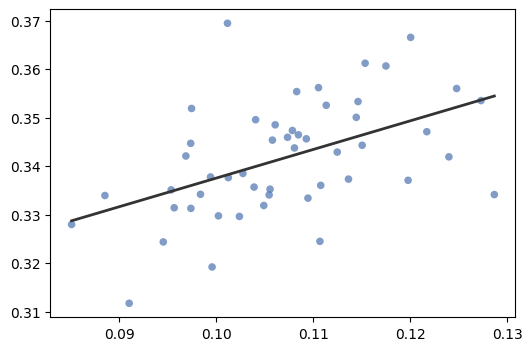

In [13]:
show_scatter_with_stats(
    team_year,
    "BB_HBP_PA",
    "OBP",
    "H1: (BB+HBP)/PA vs OBP (2021–2025)"
)


---

In [6]:
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm

def hypothesis_table(df, xcol, ycol, name):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    # 상관계수
    r, p = st.pearsonr(x, y)

    # 회귀
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    return {
        "Hypothesis": name,
        "n": len(x),
        "Pearson_r": round(r, 4),
        "p_value": round(p, 6),
        "R_squared": round(model.rsquared, 4)
    }

results = []

results.append(
    hypothesis_table(
        team_year,
        "BB_HBP_PA",
        "OBP",
        "H1: (BB+HBP)/PA → OBP"
    )
)

results.append(
    hypothesis_table(
        team_year,
        "SO_PA",
        "OBP",
        "H2: SO/PA → OBP"
    )
)

results.append(
    hypothesis_table(
        team_year,
        "OBP",
        "wRC+_PAw",
        "H3: OBP → wRC+"
    )
)

stats_df = pd.DataFrame(results)
print(stats_df)


              Hypothesis   n  Pearson_r   p_value  R_squared
0  H1: (BB+HBP)/PA → OBP  50     0.4924  0.000281     0.2425
1        H2: SO/PA → OBP  50    -0.5305  0.000074     0.2814
2         H3: OBP → wRC+  50     0.7179  0.000000     0.5155


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def show_scatter_only(df, xcol, ycol, title):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    # 회귀
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model.params.iloc[0] + model.params.iloc[1] * xs

    plt.figure(figsize=(6, 4))

    # 산점도
    plt.scatter(
        x, y,
        s=30,
        color="#4C72B0",
        alpha=0.7,
        edgecolors="none"
    )

    # 회귀선
    plt.plot(xs, ys, color="#333333", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)
    plt.tight_layout()
    plt.show()


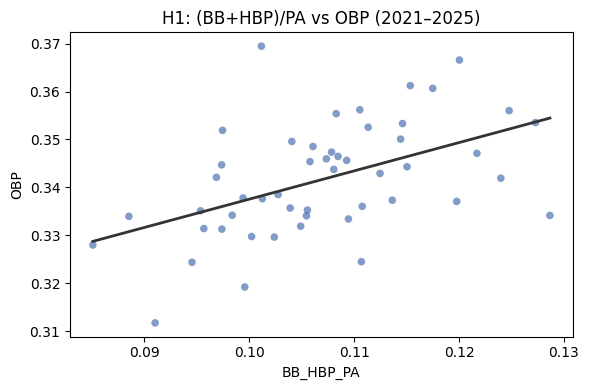

In [15]:
show_scatter_only(
    team_year,
    "BB_HBP_PA",
    "OBP",
    "H1: (BB+HBP)/PA vs OBP (2021–2025)"
)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def show_scatter_champ_highlight(df, xcol, ycol, title):
    # 전체 데이터
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)
    mask = ~(x.isna() | y.isna())
    df_plot = df[mask].copy()

    # 회귀선은 전체 기준
    X = sm.add_constant(df_plot[xcol])
    model = sm.OLS(df_plot[ycol], X).fit()

    xs = np.linspace(df_plot[xcol].min(), df_plot[xcol].max(), 100)
    ys = model.params.iloc[0] + model.params.iloc[1] * xs

    plt.figure(figsize=(6, 4))

    # 🔹 일반 팀
    normal = df_plot[~df_plot["is_champ"]]
    plt.scatter(
        normal[xcol],
        normal[ycol],
        s=30,
        color="#4C72B0",
        alpha=0.6,
        label="Non-champions",
        edgecolors="none"
    )

    # 🔸 우승팀
    champ = df_plot[df_plot["is_champ"]]
    plt.scatter(
        champ[xcol],
        champ[ycol],
        s=70,
        color="#DD8452",
        marker="*",
        label="Champions",
        edgecolors="none"
    )

    # 회귀선
    plt.plot(xs, ys, color="#333333", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


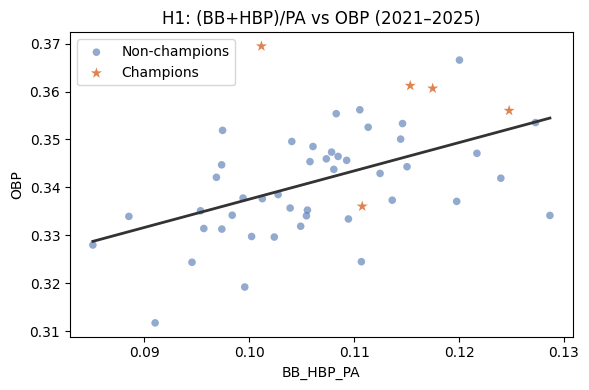

In [23]:
show_scatter_champ_highlight(
    team_year,
    "BB_HBP_PA",
    "OBP",
    "H1: (BB+HBP)/PA vs OBP (2021–2025)"
)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def show_scatter_year_champ(df, xcol, ycol, title):
    # 필요한 컬럼만 + 결측 제거
    df_plot = df[[xcol, ycol, "Year", "is_champ"]].dropna()

    # 연도별 색상 팔레트 (톤 통일)
    year_colors = {
        2021: "#4C72B0",  # blue
        2022: "#55A868",  # green
        2023: "#C44E52",  # red
        2024: "#8172B3",  # purple
        2025: "#CCB974",  # yellow-brown
    }

    plt.figure(figsize=(6, 4))

    # 🔹 연도별 일반 팀
    for year, color in year_colors.items():
        subset = df_plot[(df_plot["Year"] == year) & (~df_plot["is_champ"])]
        plt.scatter(
            subset[xcol],
            subset[ycol],
            s=30,
            color=color,
            alpha=0.6,
            edgecolors="none",
            label=str(year)
        )

    # ⭐ 우승팀 (연도 상관없이 별 마커)
    champs = df_plot[df_plot["is_champ"]]
    plt.scatter(
        champs[xcol],
        champs[ycol],
        s=90,
        color="#DD8452",
        marker="*",
        edgecolors="none",
        label="Champions"
    )

    # 회귀선 (전체 기준)
    X = sm.add_constant(df_plot[xcol])
    model = sm.OLS(df_plot[ycol], X).fit()

    xs = np.linspace(df_plot[xcol].min(), df_plot[xcol].max(), 100)
    ys = model.params.iloc[0] + model.params.iloc[1] * xs
    plt.plot(xs, ys, color="#333333", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(title)

    # 범례 정리 (중복 제거)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys(), frameon=True)

    plt.tight_layout()
    plt.show()


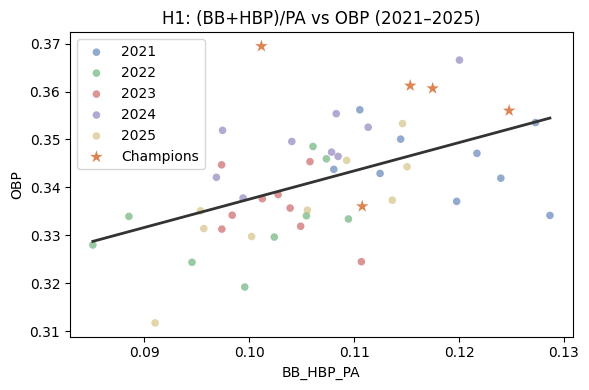

In [25]:
show_scatter_year_champ(
    team_year,
    "BB_HBP_PA",
    "OBP",
    "H1: (BB+HBP)/PA vs OBP (2021–2025)"
)


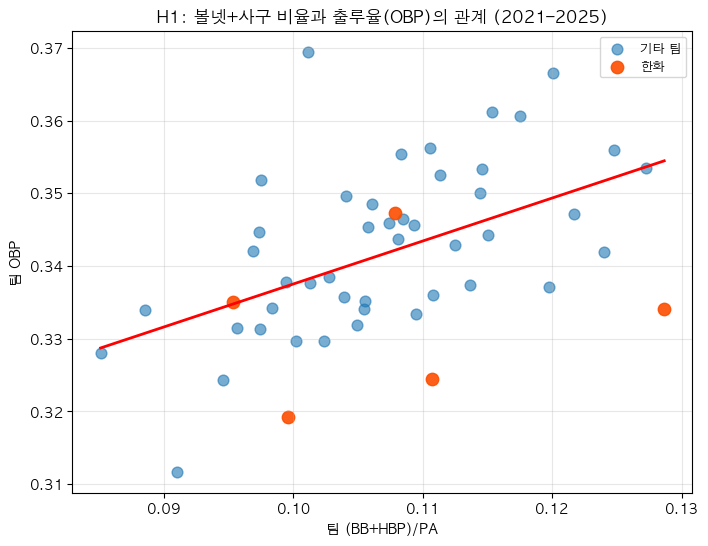

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -----------------------------
# H1용 데이터 준비
# -----------------------------
df = team_year.copy()

# x: (BB+HBP)/PA, y: OBP
x = df["BB_HBP_PA"].astype(float)
y = df["OBP"].astype(float)

mask = ~(x.isna() | y.isna())
df = df[mask].copy()
x = x[mask]
y = y[mask]

# 한화 vs 기타 팀 분리
df_hanhwa = df[df["Team"] == "한화"]
df_others = df[df["Team"] != "한화"]

# -----------------------------
# 회귀선(전체 기준)
# -----------------------------
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

def reg_line(x_vals):
    # y = a + b*x
    return model.params.iloc[0] + model.params.iloc[1] * x_vals

# -----------------------------
# 그래프 (네 스타일로)
# -----------------------------
plt.figure(figsize=(8, 6))

# 기타 팀
plt.scatter(
    df_others["BB_HBP_PA"],
    df_others["OBP"],
    alpha=0.6,
    s=60,
    label="기타 팀"
)

# 한화 강조
plt.scatter(
    df_hanhwa["BB_HBP_PA"],
    df_hanhwa["OBP"],
    color="#FC4E00",
    s=80,
    alpha=0.9,
    label="한화"
)

# 회귀선
x_sorted = np.sort(df["BB_HBP_PA"].values)
plt.plot(
    x_sorted,
    reg_line(x_sorted),
    color="red",
    linewidth=2
)

plt.xlabel("팀 (BB+HBP)/PA")
plt.ylabel("팀 OBP")
plt.title("H1: 볼넷+사구 비율과 출루율(OBP)의 관계 (2021–2025)")

plt.legend(
    loc="upper right",
    fontsize=9,
    frameon=True
)

plt.grid(alpha=0.3)
plt.show()


In [29]:
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm

def hypothesis_table_precise(df, xcol, ycol, name):
    x = df[xcol].astype(float)
    y = df[ycol].astype(float)

    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    # Pearson correlation
    r, p = st.pearsonr(x, y)

    # Regression
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    return {
        "Hypothesis": name,
        "n": len(x),
        "Pearson_r": r,                         # 반올림 ❌
        "p_value": p,                           # 원본 p-value
        "p_value_sci": f"{p:.12e}",             # 지수 표기
        "R_squared": model.rsquared             # 반올림 ❌
    }

results = []

results.append(
    hypothesis_table_precise(
        team_year,
        "BB_HBP_PA",
        "OBP",
        "H1: (BB+HBP)/PA → OBP"
    )
)

results.append(
    hypothesis_table_precise(
        team_year,
        "SO_PA",
        "OBP",
        "H2: SO/PA → OBP"
    )
)

results.append(
    hypothesis_table_precise(
        team_year,
        "OBP",
        "wRC+_PAw",
        "H3: OBP → wRC+"
    )
)

stats_df_precise = pd.DataFrame(results)
stats_df_precise


,Hypothesis,n,Pearson_r,p_value,p_value_sci,R_squared
0,H1: (BB+HBP)/PA → OBP,50,0.492420,2.807265e-04,2.807265341405e-04,0.242478
1,H2: SO/PA → OBP,50,-0.530483,7.412187e-05,7.412186741764e-05,0.281412
2,H3: OBP → wRC+,50,0.717948,4.398083e-09,4.398083192976e-09,0.515450


In [32]:
import pandas as pd

# 원본 타자 데이터
bat = pd.read_csv("../data/raw/kbo_batting_stats_by_season_1982-2025.csv")

# 최근 5개년
YEARS = [2021, 2022, 2023, 2024, 2025]
bat5 = bat[bat["Year"].isin(YEARS)].copy()

# 수치형 변환
num_cols = ["PA", "AB", "H", "BB", "HP", "SF", "SO", "HR", "wRC+"]
for c in num_cols:
    bat5[c] = pd.to_numeric(bat5[c], errors="coerce")

# wRC+ PA 가중치
bat5["wRCxPA"] = bat5["wRC+"] * bat5["PA"]

# -----------------------------
# 팀-연도 단위 집계 (HR 포함!)
# -----------------------------
team_year = (
    bat5.groupby(["Year", "Team"], as_index=False)
        .agg(
            PA=("PA", "sum"),
            AB=("AB", "sum"),
            H=("H", "sum"),
            BB=("BB", "sum"),
            HBP=("HP", "sum"),
            SF=("SF", "sum"),
            SO=("SO", "sum"),
            HR=("HR", "sum"),          # 🔥 여기 추가
            wRCxPA=("wRCxPA", "sum"),
        )
)

# -----------------------------
# 파생 변수
# -----------------------------
team_year["OBP"] = (team_year["H"] + team_year["BB"] + team_year["HBP"]) / (
    team_year["AB"] + team_year["BB"] + team_year["HBP"] + team_year["SF"]
)

team_year["BB_HBP_PA"] = (team_year["BB"] + team_year["HBP"]) / team_year["PA"]
team_year["SO_PA"] = team_year["SO"] / team_year["PA"]
team_year["HR_PA"] = team_year["HR"] / team_year["PA"]      # ✅ 이제 생성됨
team_year["wRC+_PAw"] = team_year["wRCxPA"] / team_year["PA"]


In [33]:
import scipy.stats as st
import statsmodels.api as sm

def hypothesis_hr_pa_obp(df):
    x = df["HR_PA"].astype(float)
    y = df["OBP"].astype(float)

    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    r, p = st.pearsonr(x, y)

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    return {
        "Hypothesis": "H4: HR/PA → OBP",
        "n": len(x),
        "Pearson_r": r,
        "p_value": p,
        "p_value_sci": f"{p:.12e}",
        "R_squared": model.rsquared
    }

hr_result = hypothesis_hr_pa_obp(team_year)
pd.DataFrame([hr_result])


,Hypothesis,n,Pearson_r,p_value,p_value_sci,R_squared
0,H4: HR/PA → OBP,50,0.375096,0.007274,7.274221364843e-03,0.140697


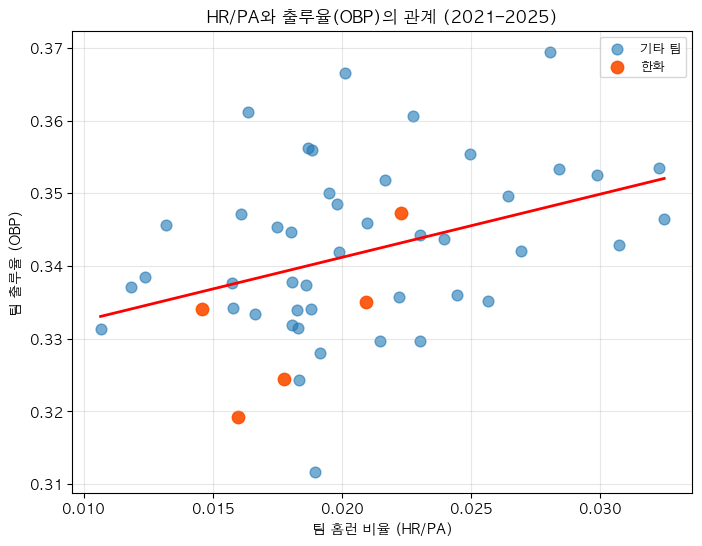

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -----------------------------
# 데이터 준비
# -----------------------------
df = team_year.copy()

x = df["HR_PA"].astype(float)
y = df["OBP"].astype(float)

mask = ~(x.isna() | y.isna())
df = df[mask].copy()

df_hanhwa = df[df["Team"] == "한화"]
df_others = df[df["Team"] != "한화"]

# -----------------------------
# 회귀선 (전체 기준)
# -----------------------------
X = sm.add_constant(df["HR_PA"])
model = sm.OLS(df["OBP"], X).fit()

def reg_line(x_vals):
    return model.params.iloc[0] + model.params.iloc[1] * x_vals

# -----------------------------
# 그래프
# -----------------------------
plt.figure(figsize=(8, 6))

# 기타 팀
plt.scatter(
    df_others["HR_PA"],
    df_others["OBP"],
    alpha=0.6,
    s=60,
    label="기타 팀"
)

# 한화 강조
plt.scatter(
    df_hanhwa["HR_PA"],
    df_hanhwa["OBP"],
    color="#FC4E00",
    s=80,
    alpha=0.9,
    label="한화"
)

# 회귀선
x_sorted = np.sort(df["HR_PA"].values)
plt.plot(
    x_sorted,
    reg_line(x_sorted),
    color="red",
    linewidth=2
)

plt.xlabel("팀 홈런 비율 (HR/PA)")
plt.ylabel("팀 출루율 (OBP)")
plt.title("HR/PA와 출루율(OBP)의 관계 (2021–2025)")

plt.legend(
    loc="upper right",
    fontsize=9,
    frameon=True
)

plt.grid(alpha=0.3)
plt.show()
